# Programming for Data Science and Artificial Intelligence

## Case Study - Loan Prediction

In this workshop we will be working on a dataset called the Loan Prediction dataset.  This dataset concern the data of loan application and the result whether if the loan was approved or not.

We are given 2 set, the training set and the test set.

The **training set** contains 614 samples and 13 features, 12 of which are the independent variables and the last feature `Loan_Status` is the dependent variable.

The **test set** contains 367 samples with the same 12 features but without the `Loan_Status` columns. So it will be representing the unseen data that we will be implementing our model on.

## 1. Import data

In [1]:
import pandas as pd

train_data = pd.read_csv('data/train_LoanPrediction.csv')
test_data  = pd.read_csv('data/test_LoanPrediction.csv')

In [2]:
# Check the shape of Training and Test set
print('Training data shape : ', train_data.shape)
print('Test data shape     : ', test_data.shape)

Training data shape :  (614, 13)
Test data shape     :  (367, 12)


In [3]:
# Let's see the "head" of the training set
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# Let's see the "info" of the training set
# Notice that this will tell us the  Non-null counts and the dtypes of each colum
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
### also nice to check whether this dataset is imbalanced in the beginning
train_data['Loan_Status'].value_counts(normalize=True)  #hmm..imbalanced...

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

## 2. Cleaning

### Check missing values

In [6]:
def show_missing(train_data, test_data):
    print('Missing values in Train data: \n', train_data.isna().sum())
    print("="*30)
    print('Missing values in Test data: \n', test_data.isna().sum())

In [7]:
show_missing(train_data, test_data)

Missing values in Train data: 
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Missing values in Test data: 
 Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


### Filling categorical values


Let's first focus on the `Married` column. We can see from the table above that the `Married` has 3 missing values in the training set and 0 missing values in the test set so let's fill the training set!

We will use the distribution over the train dataset then fill in the missing values in **approximately the same ratio with fillna()**

Here are the steps:
1. Compute ratio in the **training** set
2. Divide the missing values based on ratio
3. Fill in the missing values according to the ratio

In [8]:
# count the values in 'Married' columns.
print(train_data['Married'].value_counts())

Yes    398
No     213
Name: Married, dtype: int64


In [9]:
# we can get the ratio instead
ratio = train_data['Married'].value_counts(normalize=True)
ratio

Yes    0.651391
No     0.348609
Name: Married, dtype: float64

In [10]:
ratio.index[0]
ratio.index[1]

'No'

In [11]:
ratio[0]
ratio[1]

0.3486088379705401

In [12]:
list(ratio.values)

[0.6513911620294599, 0.3486088379705401]

In [13]:
list(ratio.index)

['Yes', 'No']

In [14]:
#let's fill in!
import numpy as np

#this is a bit advanced, but it's easy technique for filling with ratios....
train_data['Married'].fillna(pd.Series(np.random.choice([ratio.index[0], ratio.index[1]], 
                        p=[ratio[0], ratio[1]], size=len(train_data))), inplace=True)

In [15]:
show_missing(train_data, test_data)

Missing values in Train data: 
 Loan_ID               0
Gender               13
Married               0
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Missing values in Test data: 
 Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


But we still have other categorical columns.  For some of them we need to fill in both the training and test set!

So let's write a function that can calculate the ratio from the training data and fill the missing values accordingly.

In [16]:
#filter out all categorical columns with missing values
categorical = train_data.select_dtypes(include=['object'])
cat_with_missing = categorical.columns[categorical.isna().any()] 
cat_with_missing

Index(['Gender', 'Dependents', 'Self_Employed'], dtype='object')

In [17]:
#check missing value in these columns
show_missing(train_data[cat_with_missing], test_data[cat_with_missing])

Missing values in Train data: 
 Gender           13
Dependents       15
Self_Employed    32
dtype: int64
Missing values in Test data: 
 Gender           11
Dependents       10
Self_Employed    23
dtype: int64


In [18]:
# write a nice function to calculate ratio and fillna
def fill_data_with_ratio(train_data, test_data, column_name):
    
    ratio = train_data[column_name].value_counts(normalize=True)
    
    train_data[column_name].fillna(
        pd.Series(np.random.choice(list(ratio.index), 
        p=list(ratio.values), 
        size=len(train_data))), 
        inplace=True)
    
    test_data[column_name].fillna(
        pd.Series(np.random.choice(list(ratio.index), 
        p=list(ratio.values), 
        size=len(test_data))), 
        inplace=True)

In [19]:
# simple loop!
for col in cat_with_missing:
    fill_data_with_ratio(train_data, test_data, col)

In [20]:
show_missing(train_data[cat_with_missing], test_data[cat_with_missing])

Missing values in Train data: 
 Gender           0
Dependents       0
Self_Employed    0
dtype: int64
Missing values in Test data: 
 Gender           0
Dependents       0
Self_Employed    0
dtype: int64


Let's check what are the other columns we still have to fill....

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [22]:
show_missing(train_data, test_data)

Missing values in Train data: 
 Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Missing values in Test data: 
 Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


### Filling "numerical" categorical values

There are two hidden categorical column but which is numerical.

In [23]:
train_data['Credit_History'].unique()

array([ 1.,  0., nan])

In [24]:
train_data['Loan_Amount_Term'].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

Thus, let's also fill them accordingly...

In [25]:
for col in ['Credit_History', 'Loan_Amount_Term']:
    fill_data_with_ratio(train_data, test_data, col)

In [26]:
show_missing(train_data, test_data)

Missing values in Train data: 
 Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64
Missing values in Test data: 
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           5
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


### Filling Numerical Values

`LoanAmount` still has some missing values.

We should check the distribution of the data before deciding how to fill them.

<Figure size 576x288 with 0 Axes>

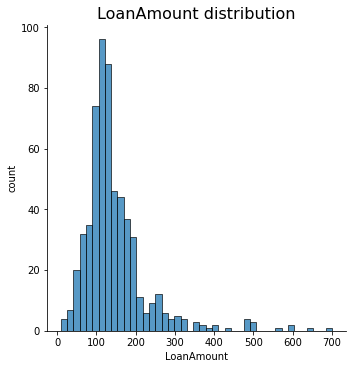

In [27]:
# plot a histogram to see the data distribution of 'LoanAmount'
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.displot(train_data['LoanAmount'])
plt.title('LoanAmount distribution', size=16)
plt.ylabel('count');

<AxesSubplot:>

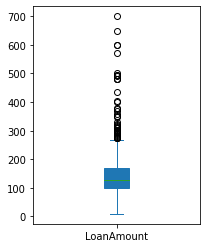

In [28]:
# also try plot a box plot
train_data['LoanAmount'].plot(kind='box', figsize=(3,4), patch_artist=True)

There are some outliers so we will be using the median over the training set to fill the missing values to avoid effects of outliers on the center value.

In [29]:
# Use the median of the Training set to fill both the training and test set.
train_data['LoanAmount'].fillna((train_data['LoanAmount'].median()), inplace=True)
test_data['LoanAmount'].fillna((train_data['LoanAmount'].median()), inplace=True)

In [30]:
show_missing(train_data, test_data)

Missing values in Train data: 
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Missing values in Test data: 
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


### Filling some inconsistent column

Dependent has some weird value which is 3+, which will not allow the machine learning to work properly.  So let's replace all 3+ with 4.

In [31]:
train_data['Dependents'].unique()

array(['0', '1', '2', '3+'], dtype=object)

In [32]:
test_data['Dependents'].unique()

array(['0', '1', '2', '3+'], dtype=object)

In [33]:
train_data['Dependents'].replace('3+', '4', inplace = True)
test_data['Dependents'].replace('3+', '4', inplace = True)

We are finally done with filling na!

### Dropping Loan ID

We have one column which does not seem to be useful later on for our prediction, i.e., Loan ID.  So let's remove that.

In [34]:
train_data.drop(columns=['Loan_ID'], inplace=True)
test_data.drop(columns=['Loan_ID'], inplace=True)

train_data.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

## 3. Exploratory Data Analysis

Last time we used correlation matrix.  However, correlation matrix is not so useful in classification problem.  Instead, we shall use boxplot to quickly plot relationship between variables.

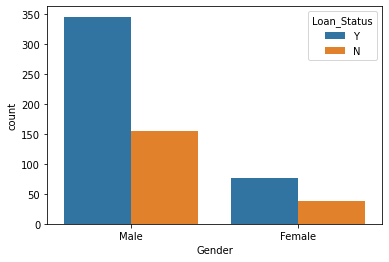

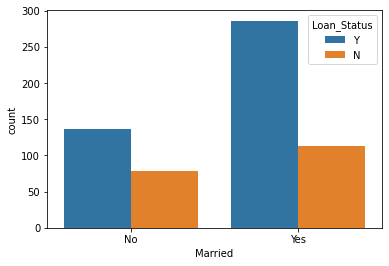

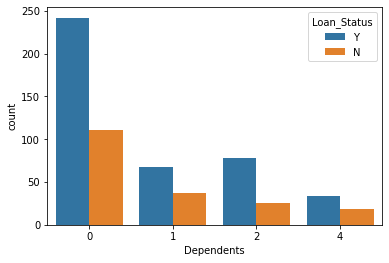

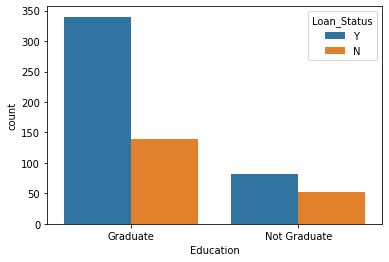

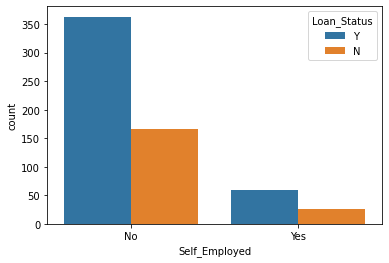

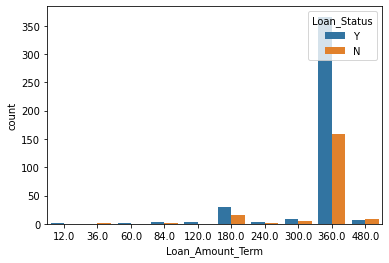

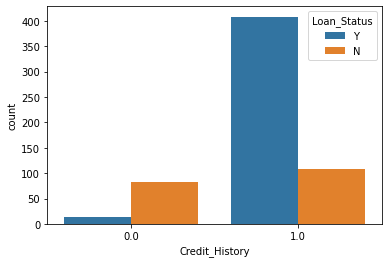

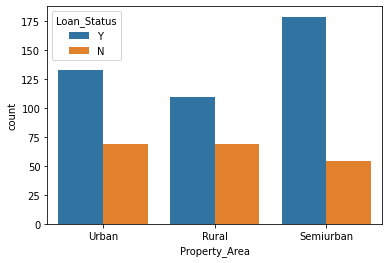

In [35]:
categorical = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']

for col in categorical:
    sns.countplot(x=col,data=train_data,hue='Loan_Status')
    plt.show()

What we learn:
    
1. Male are more likely to get loans
2. Married people are more likely to get loans
3. No dependents are more likely to get loans
4. Graduates are more likely to get loans
5. Not self-employed is more likely to get loans
6. Majority of loans are 360 months
7. People with credit history are more likely to get loans
8. Semiurban people are more likely to get loans

Let's also look at numerical column.

In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


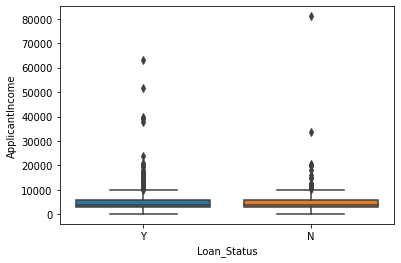

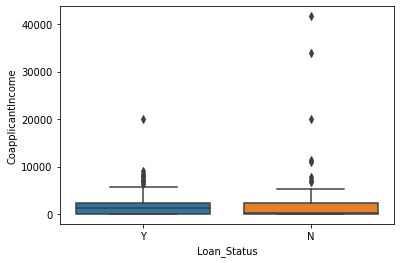

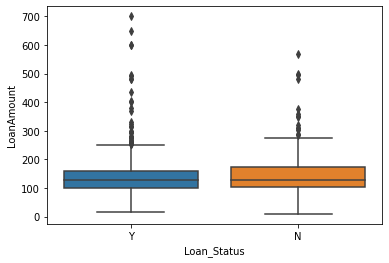

In [37]:
numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for col in numerical:
    sns.boxplot(y=col,data=train_data,x='Loan_Status')
    plt.show()

It's clear that numerical columns have little relationship....

## 4) Modeling

Before we can do modeling, let's change everything to int

### Changing string to int

In [38]:
# Next, let's convert the `Gender` column to 0.0 for Male and 1.0 for Female
train_data['Gender'].replace('Male', 0.0, inplace = True)
train_data['Gender'].replace('Female', 1.0, inplace = True)

test_data['Gender'].replace('Male', 0.0, inplace = True)
test_data['Gender'].replace('Female', 1.0, inplace = True)

It's tiring to run one by one...thus, let's first check which column is still not integer yet

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    float64
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 57.7+ KB


Also run head() to see whether some could be already numbers but of string

In [40]:
train_data.head(1)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y


Hmm...so dependents is already in integer form but of string, so let's fix that first easily

In [41]:
# Convert values in 'Dependents' to int
train_data['Dependents'] = train_data['Dependents'].astype(int)
test_data['Dependents']  = test_data['Dependents'].astype(int)

Ok...now let's make some magic function that would convert everything to integer

In [42]:
for col in train_data.columns:
    if(train_data[col].dtype == 'object'):
        train_data[col]= train_data[col].astype('category') #first convert to category
        train_data[col] = train_data[col].cat.codes  #exploit cat.codes
        
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    float64
 1   Married            614 non-null    int8   
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int8   
 4   Self_Employed      614 non-null    int8   
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int8   
 11  Loan_Status        614 non-null    int8   
dtypes: float64(5), int64(2), int8(5)
memory usage: 36.7 KB


Repeat this for test_data

In [43]:
for col in test_data.columns:
    if(test_data[col].dtype == 'object'):
        test_data[col]= test_data[col].astype('category') #first convert to category
        test_data[col] = test_data[col].cat.codes  #exploit cat.codes
        
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    float64
 1   Married            614 non-null    int8   
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    int8   
 4   Self_Employed      614 non-null    int8   
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int8   
 11  Loan_Status        614 non-null    int8   
dtypes: float64(5), int64(2), int8(5)
memory usage: 36.7 KB


### Setting X and y

Let's set X and y.  For X, we shall drop Loan_Status, and all numeric data.  For y, it is Loan_Status

In [44]:
X_train = train_data.drop(columns=['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 'Loan_Status'])
y_train = train_data['Loan_Status']

In [45]:
X_test  = test_data.drop(columns=numerical)
#note that our test set has no loan_status because this is what we have...

### Scaling

In [46]:
# split X and y into X_train, X_val, y_train, y_val
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### Train a classification model

In [47]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as sv

from sklearn.metrics import classification_report

# models that we will be using, put them in a list
algorithms = [lr(), dt(), knn(), rf(), sv()]

# The names of the models
algorithm_names = ["Logistic Regression", "Decision Tree", "KNeighbors", "Random-Forest Regressor", "Support Vector Machine"]

Let's do some simple cross-validation here....(note that you can also do nested cv here...but I am too lazy)

In [48]:
from sklearn.model_selection import KFold, cross_val_score

#lists for keeping mse
train_mse = []
test_mse = []

#defining splits
kfold = KFold(n_splits=5, shuffle=True)

for i, model in enumerate(algorithms):
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(f"{algorithm_names[i]} - Score: {scores}; Mean: {scores.mean()}")

Logistic Regression - Score: [0.84552846 0.82113821 0.78861789 0.74796748 0.79508197]; Mean: 0.799666799946688
Decision Tree - Score: [0.7398374  0.7804878  0.72357724 0.71544715 0.74590164]; Mean: 0.7410502465680395
KNeighbors - Score: [0.75609756 0.77235772 0.77235772 0.73170732 0.78688525]; Mean: 0.7638811142209783
Random-Forest Regressor - Score: [0.80487805 0.78861789 0.73170732 0.73170732 0.79508197]; Mean: 0.7703985072637611
Support Vector Machine - Score: [0.78861789 0.78861789 0.80487805 0.82926829 0.7704918 ]; Mean: 0.7963747834199653


### Grid Search

In [49]:
from sklearn.model_selection import GridSearchCV

model = lr()

param_grid = dict()
param_grid['solver'] = ['newton-cg', 'lbfgs', 'liblinear']

grid = GridSearchCV(model, param_grid, cv=kfold, refit=True, scoring='f1_macro')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1_macro')

In [50]:
grid.best_params_

{'solver': 'newton-cg'}

In [51]:
# Find your grid_search's best score
best_accuracy = grid.best_score_

In [52]:
best_accuracy

0.7212652156458422

### Inference

In [53]:
yhat = grid.predict(X_test)
print(yhat)  #submit this to kaggle

[1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1]


### Save model for deployment

In [54]:
import pickle

# save the model to disk
filename = 'model/loan.model'
pickle.dump(grid, open(filename, 'wb'))

### Loading model

In [55]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
yhat = loaded_model.predict(X_test)